In [1]:
import sys

ABS_PATH = "Path to GPflow-NARX"
sys.path.append(ABS_PATH + "GPflow-NARX")

import gpflow
from gpflow import default_float, default_jitter
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

my_devices = tf.config.list_physical_devices(device_type="CPU")
tf.config.set_visible_devices(devices=my_devices)

from data.predator_prey.pp_data_generator import Generator
from utils.utils import optimize_model_with_scipy, plot_model, plot_model_samples

import gpnarx
from gpnarx.models.narx import NARX_parameters

In [2]:
# The lines below are specific to the notebook format
%matplotlib inline
plt.rcParams["figure.figsize"] = (12, 6)

# supress tensorflow warnings
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# set random seeds
np.random.seed(0)
tf.random.set_seed(0)

In [3]:
y_train, y_test, x_train, x_test, u_train, u_test = Generator(
    noise_levels=[0.01, 0.01]
).get_predator_prey_data()

In [4]:
narx_params = NARX_parameters(nk=1, nb=4, nq=1, na=4)
_, _, ndim = narx_params.get_input_dims(u_train, y_train)

kernel_list = [
    gpflow.kernels.Linear() + gpflow.kernels.Matern52(lengthscales=[1.0] * ndim),
    gpflow.kernels.Linear() + gpflow.kernels.Matern52(lengthscales=[1.0] * ndim),
]

kernel = gpflow.kernels.SeparateIndependent(kernel_list)

lik = gpnarx.likelihoods.MOLikelihood(
    [
        gpnarx.likelihoods.Gaussian_with_sampler(1.0),
        gpnarx.likelihoods.Gaussian_with_sampler(1.0),
    ]
)

inducing_variable_wrapper = (
    lambda X: gpflow.inducing_variables.SeparateIndependentInducingVariables(
        [
            gpflow.inducing_variables.InducingPoints(Z[:100])
            for Z in [X for _ in range(y_train.shape[1])]
        ]
    )
)

m = gpnarx.models.MultivariateSGPR_NARX(
    data=(u_train, y_train),
    narx_params=narx_params,
    inducing_variable_wrapper=inducing_variable_wrapper,
    kernel=kernel,
    likelihood=lik,
)

logf = optimize_model_with_scipy(m, compile_graph=True, libs=(tf, gpflow))

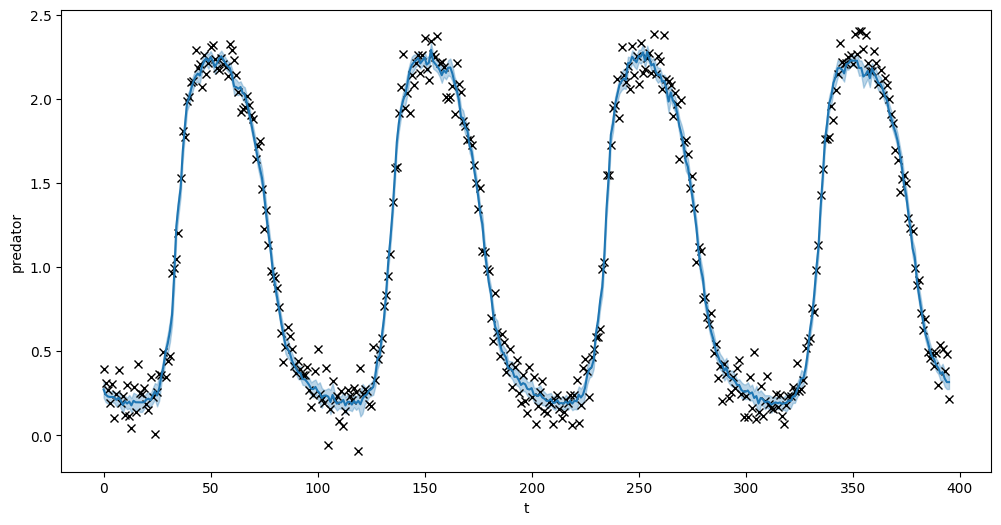

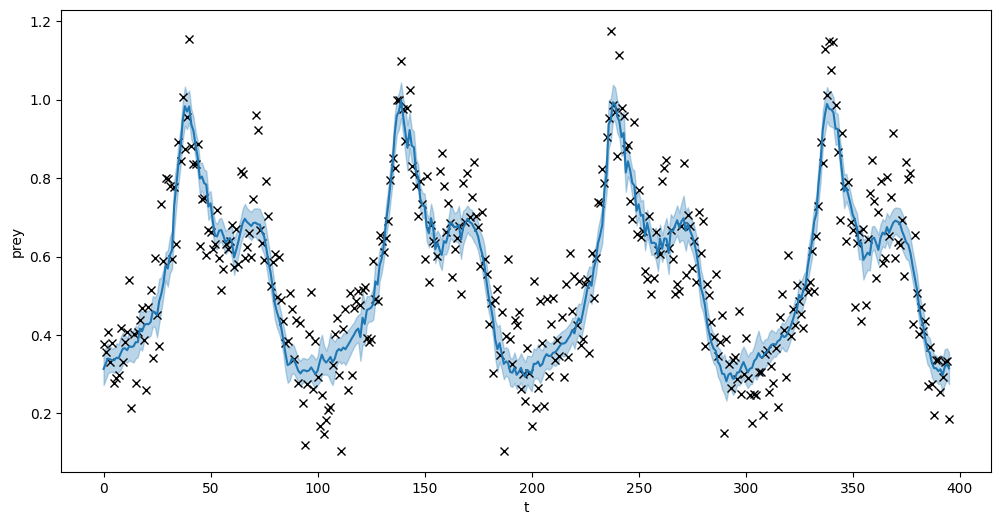

In [5]:
mean, var = m.predict_latent(Unew=u_test, Ynew=y_test)
mean, var = mean.numpy(), var.numpy()

# Plot the response
plot_model(mean, var, y_test[m.narx_params.max_lag :], output_list=["predator", "prey"])

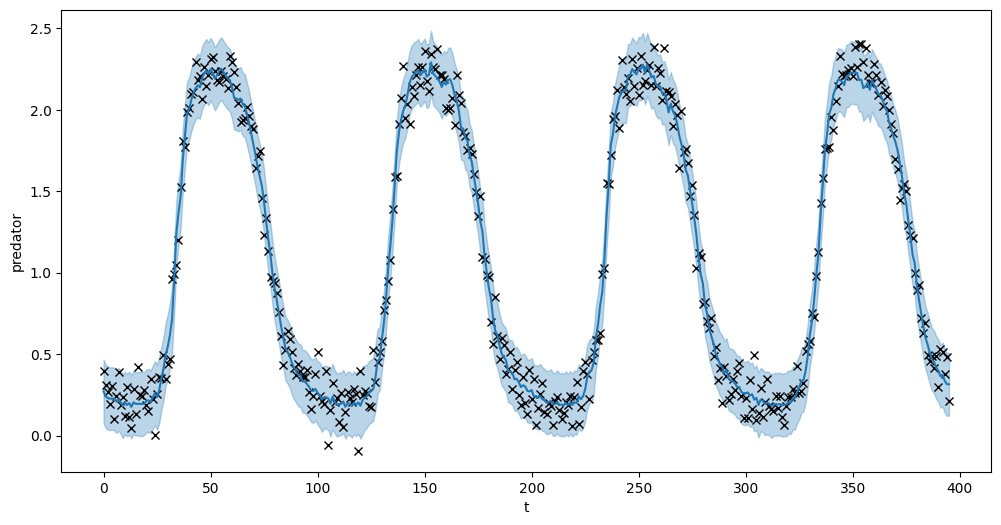

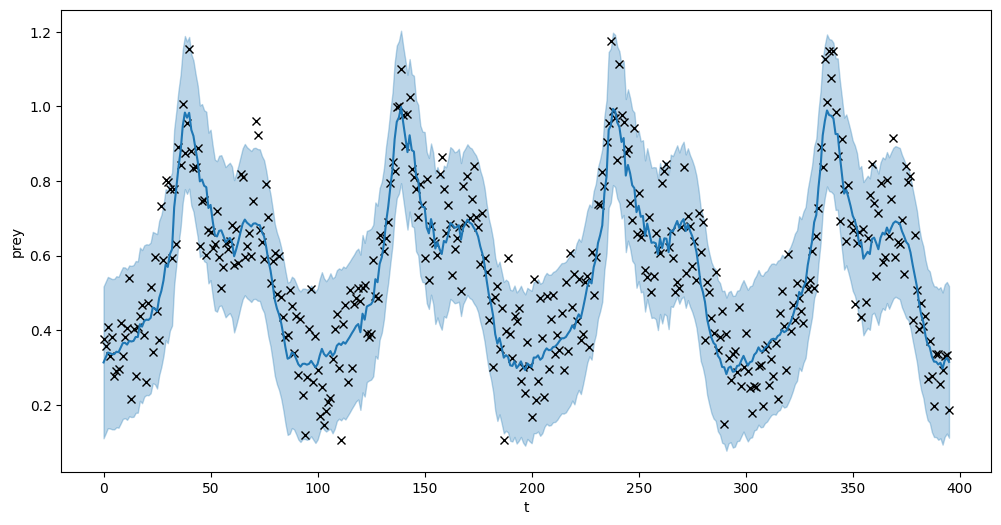

In [6]:
mean, var = m.predict_noisy(Unew=u_test, Ynew=y_test)
mean, var = mean.numpy(), var.numpy()

# Plot the response
plot_model(mean, var, y_test[m.narx_params.max_lag :], output_list=["predator", "prey"])

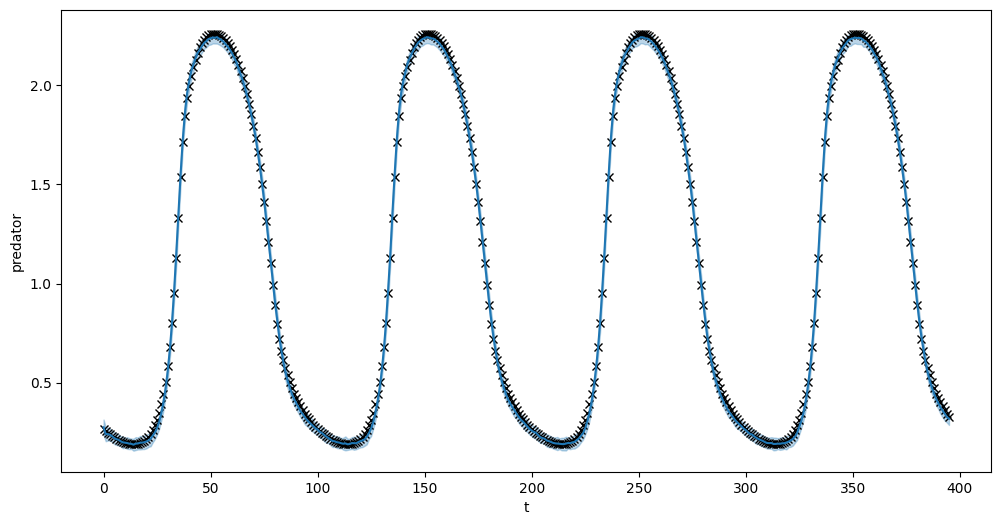

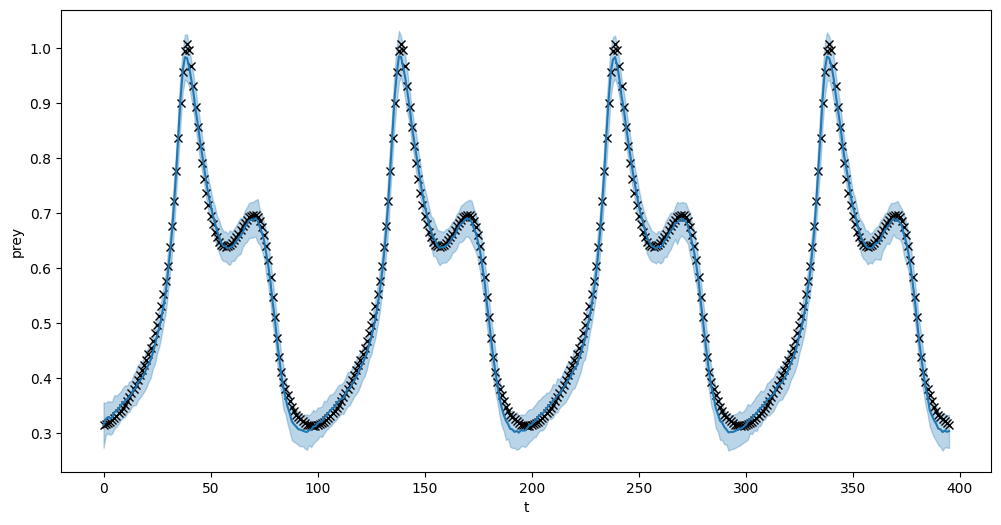

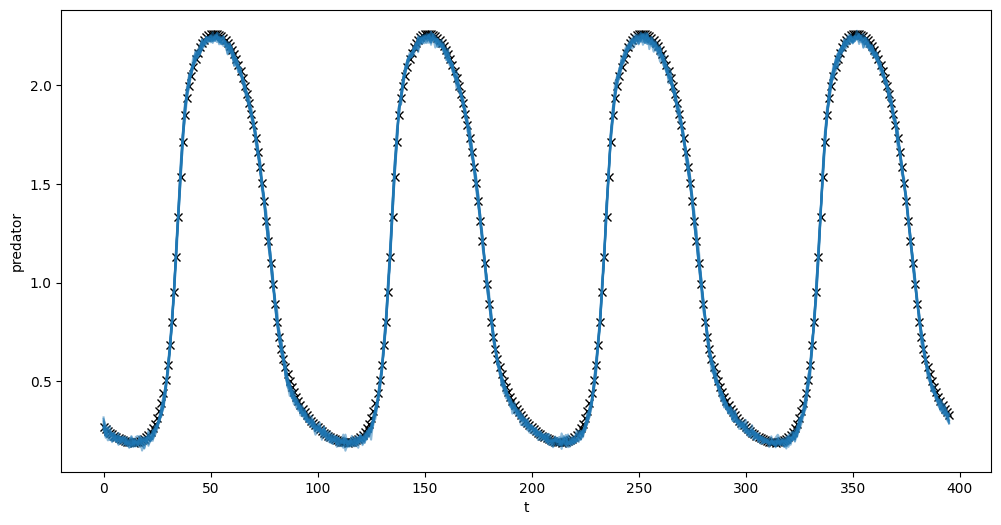

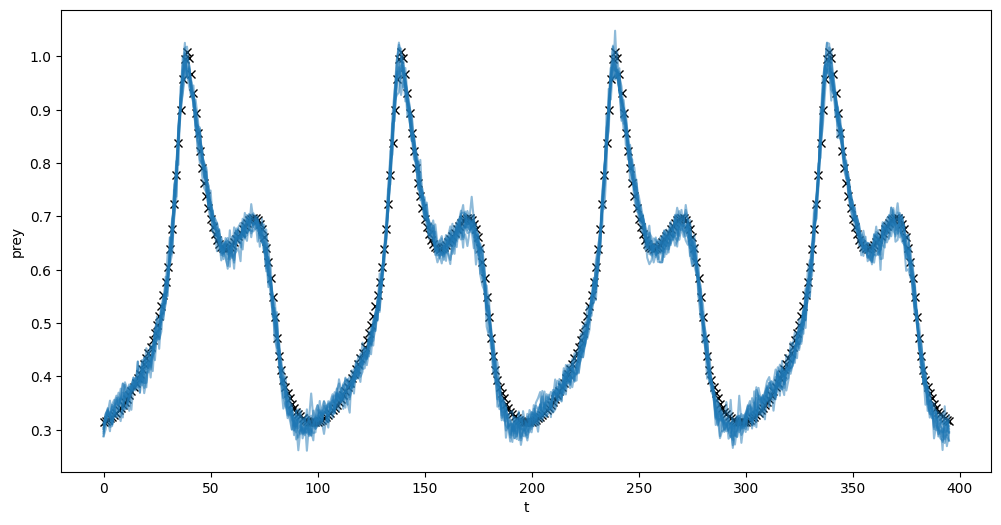

In [7]:
samples = m.simulate_latent_montecarlo_independent(
    y_initial=tf.constant(y_test)[: m.narx_params.max_lag],
    U=tf.constant(u_test),
    propagate_error=False,
    num_samples=100,
)
samples = samples.numpy()
mean, var = samples.mean(axis=0), samples.var(axis=0)

# Plot the first two moments of the response
plot_model(mean, var, x_test[m.narx_params.max_lag :], output_list=["predator", "prey"])

# Plot the sampled response
plot_model_samples(
    samples,
    x_test[m.narx_params.max_lag :],
    ["predator", "prey"],
    num_samples=10,
    alpha=0.5,
)

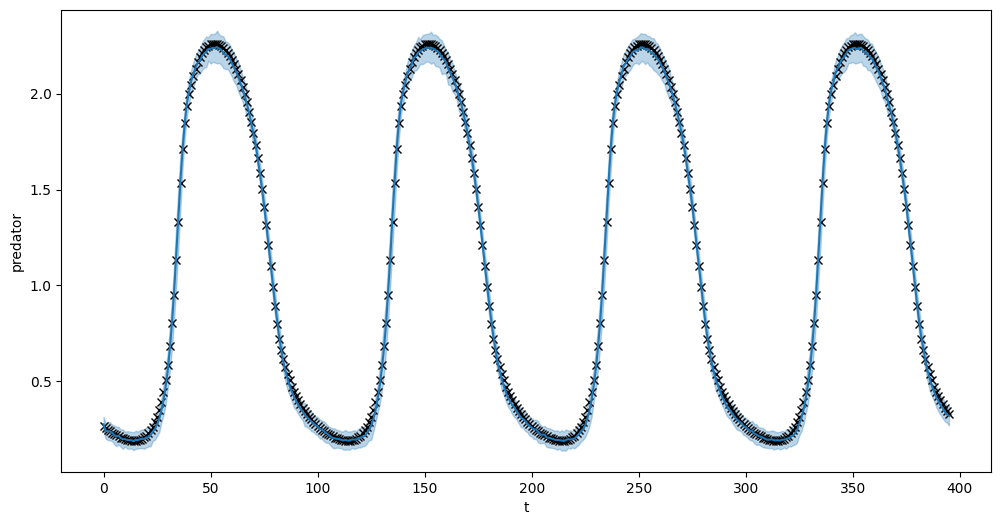

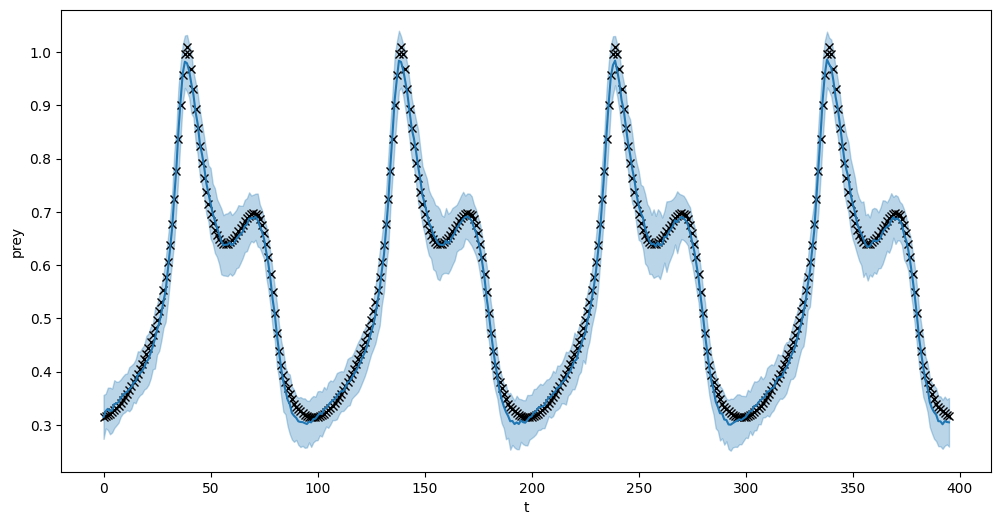

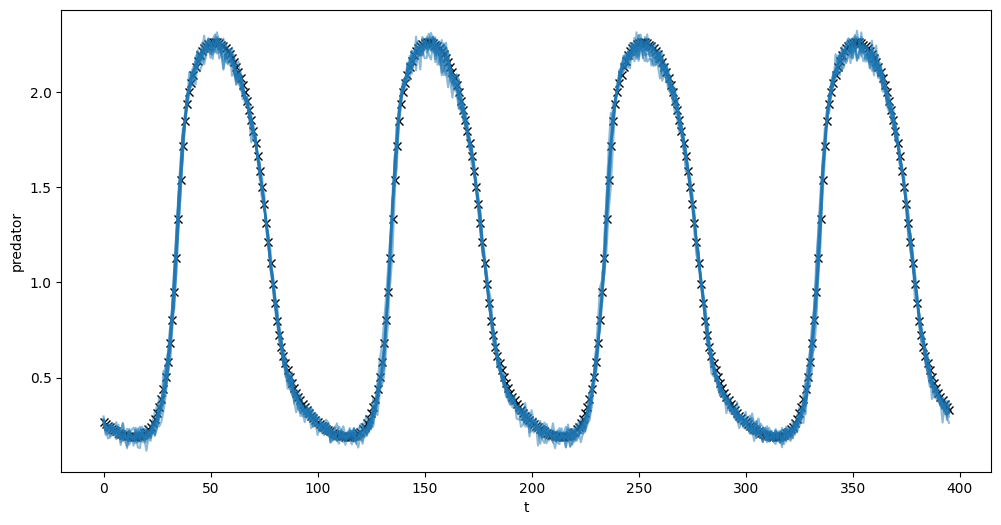

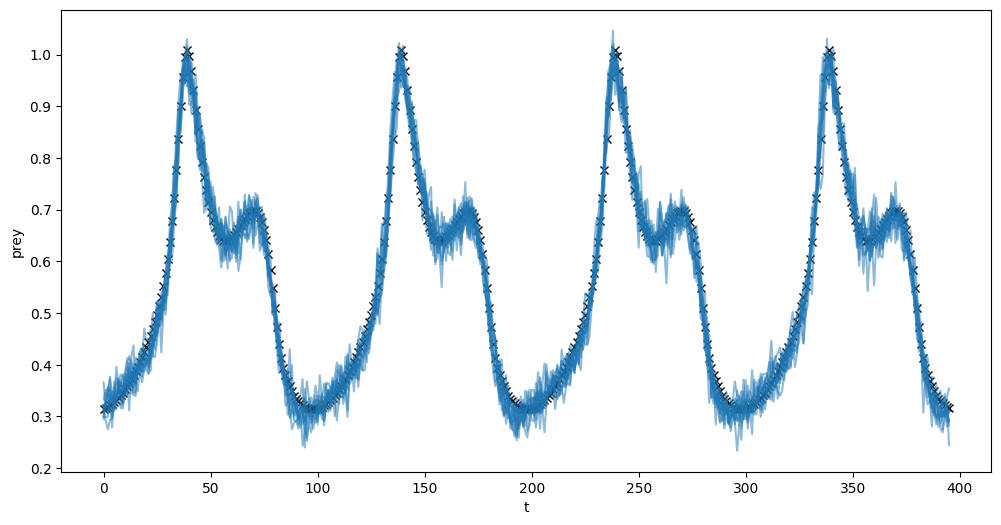

In [8]:
samples = m.simulate_latent_montecarlo_independent(
    y_initial=tf.constant(y_test)[: m.narx_params.max_lag],
    U=tf.constant(u_test),
    propagate_error=True,
    num_samples=100,
)
samples = samples.numpy()
mean, var = samples.mean(axis=0), samples.var(axis=0)

# Plot the first two moments of the response
plot_model(mean, var, x_test[m.narx_params.max_lag :], output_list=["predator", "prey"])

# Plot the sampled response
plot_model_samples(
    samples,
    x_test[m.narx_params.max_lag :],
    ["predator", "prey"],
    num_samples=10,
    alpha=0.5,
)

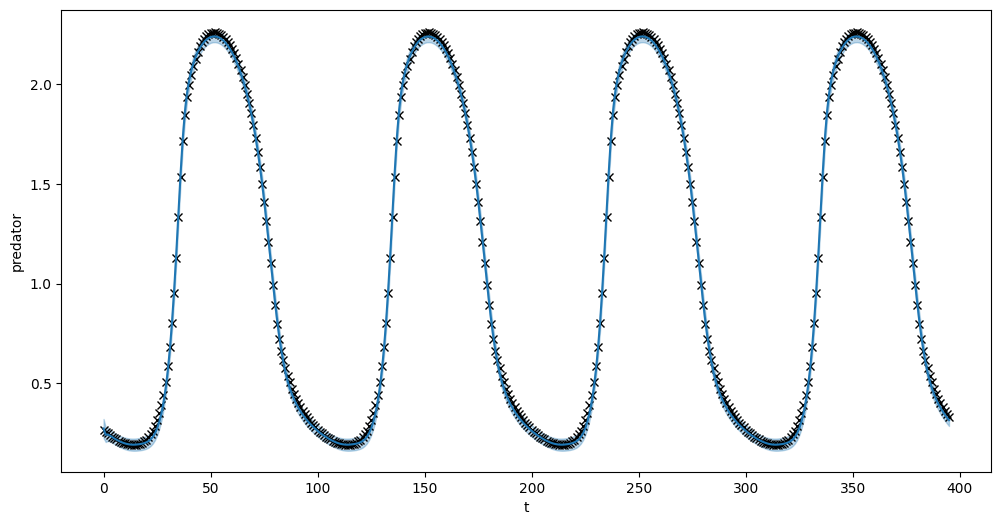

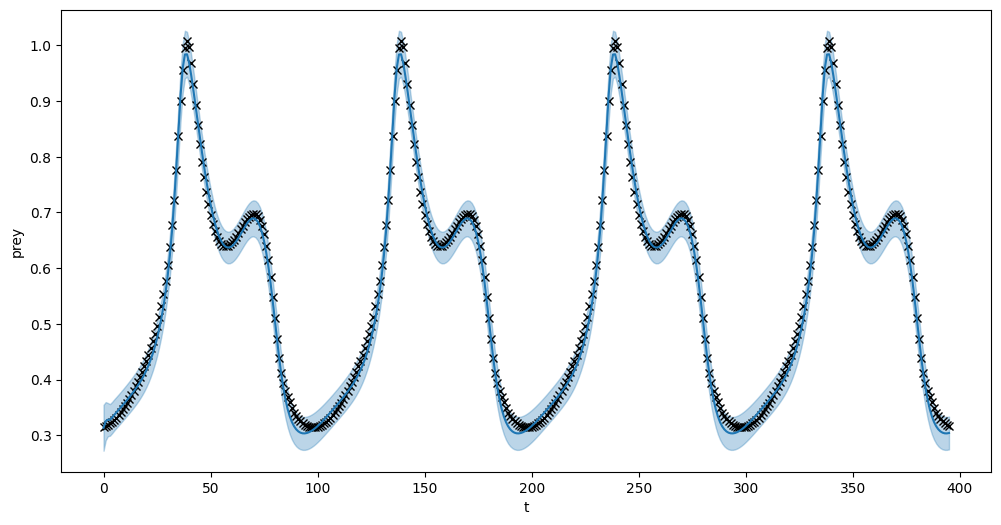

In [9]:
mean, var = m.simulate_naive_independent(
    y_initial=tf.constant(y_test)[: m.narx_params.max_lag], U=tf.constant(u_test)
)
mean, var = mean.numpy(), var.numpy()

# Plot the response
plot_model(mean, var, x_test[m.narx_params.max_lag :], output_list=["predator", "prey"])

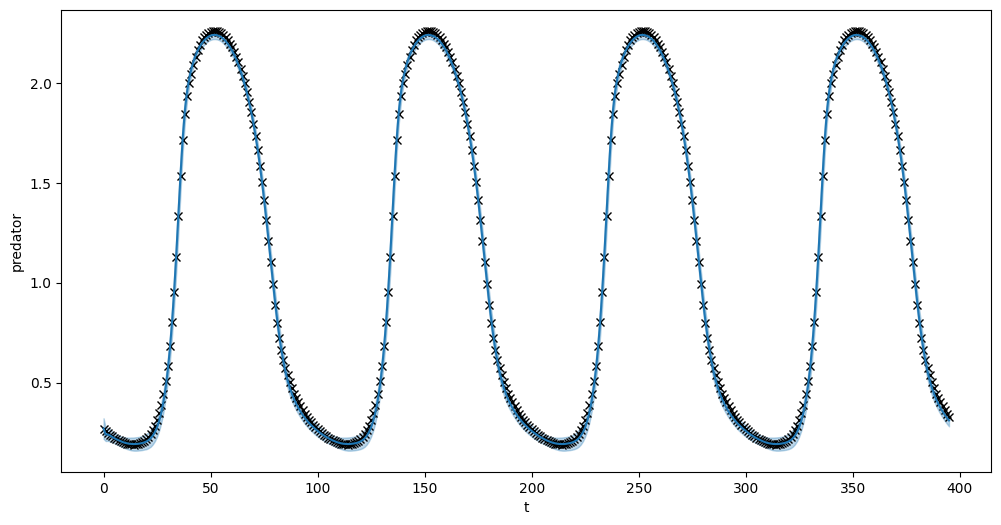

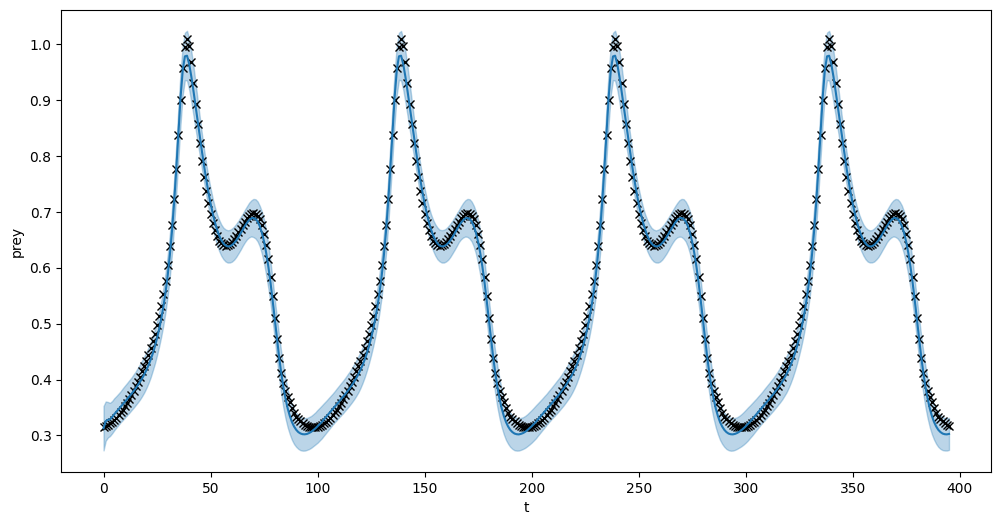

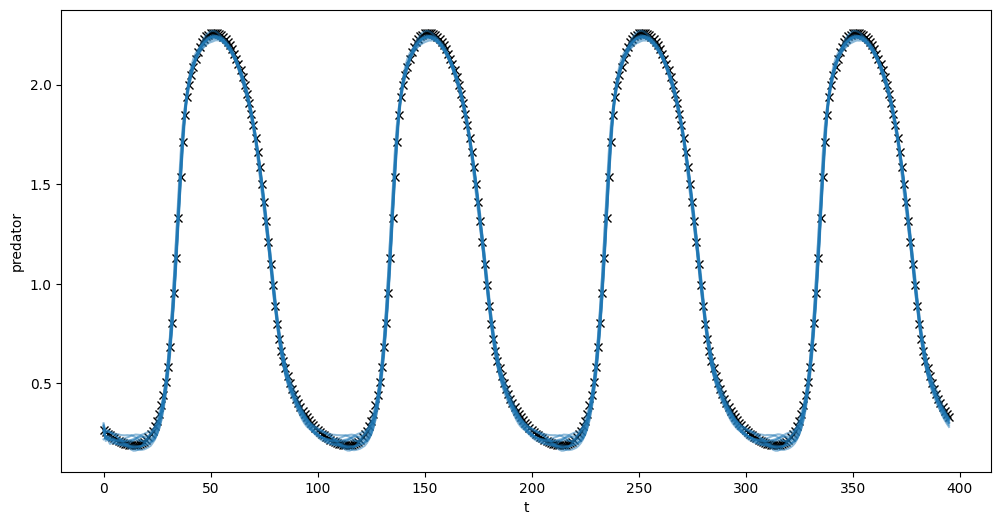

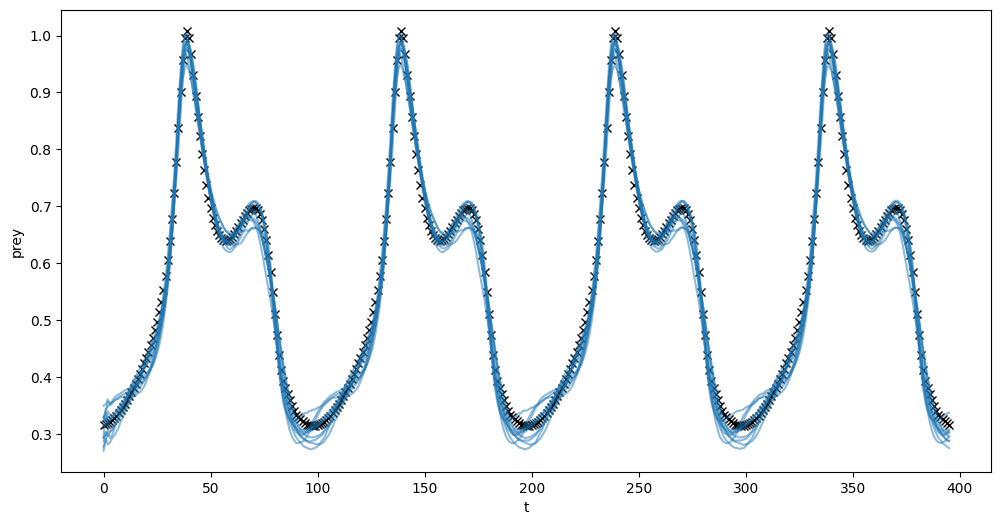

In [10]:
samples = m.simulate_latent_montecarlo_correlated(
    y_initial=tf.constant(y_test)[: m.narx_params.max_lag],
    U=tf.constant(u_test),
    propagate_error=False,
    num_samples=100,
    std_threshold=tf.math.sqrt(tf.constant(default_jitter(), dtype=default_float())),
)
samples = samples.numpy()
mean, var = samples.mean(axis=0), samples.var(axis=0)

# Plot the first two moments of the response
plot_model(mean, var, x_test[m.narx_params.max_lag :], output_list=["predator", "prey"])

# Plot the sampled response
plot_model_samples(
    samples,
    x_test[m.narx_params.max_lag :],
    ["predator", "prey"],
    num_samples=10,
    alpha=0.5,
)

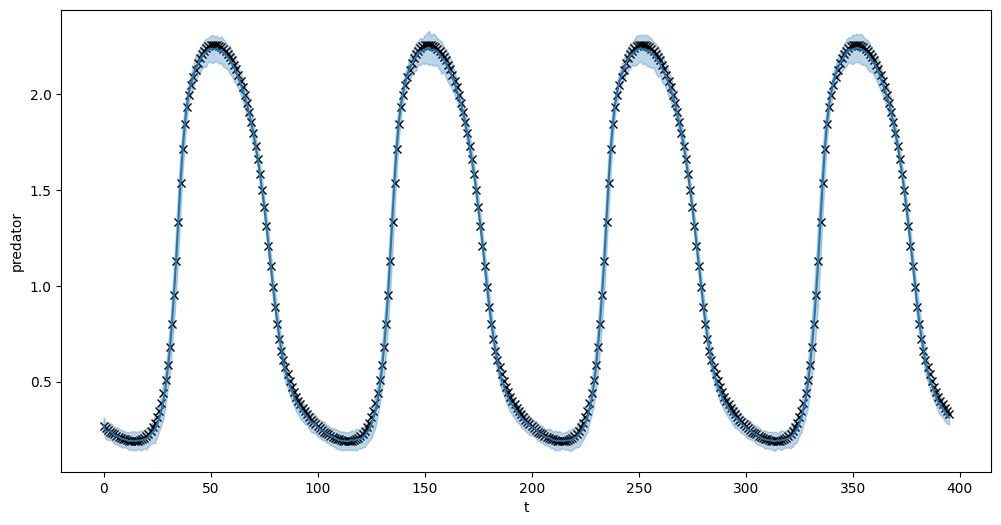

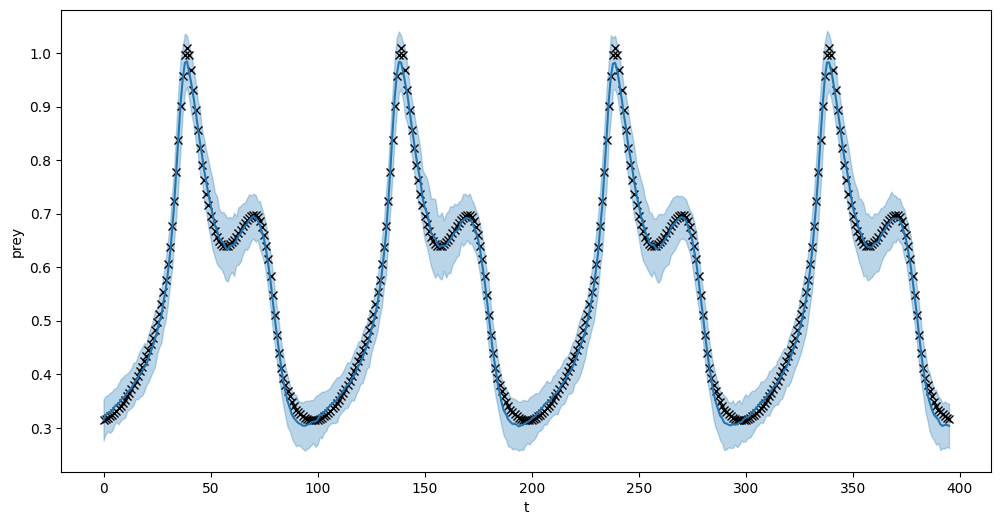

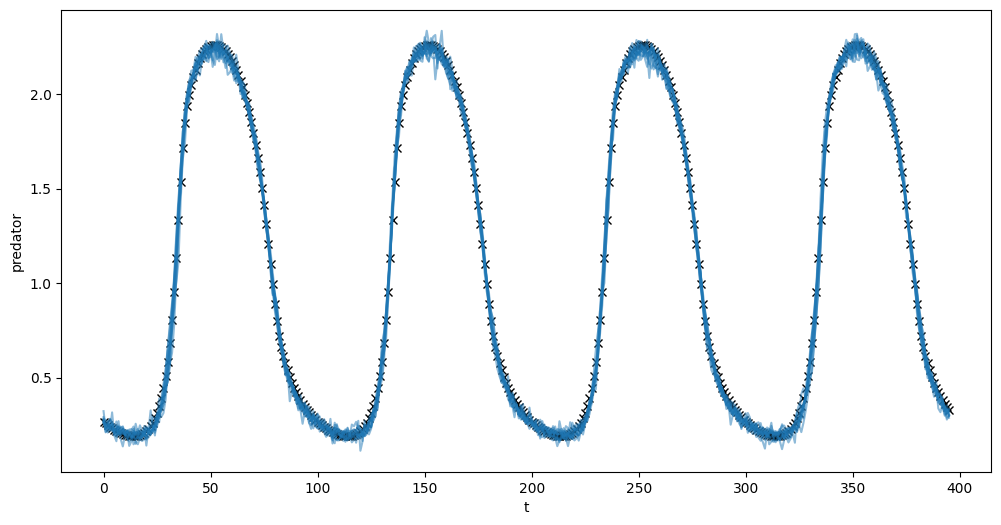

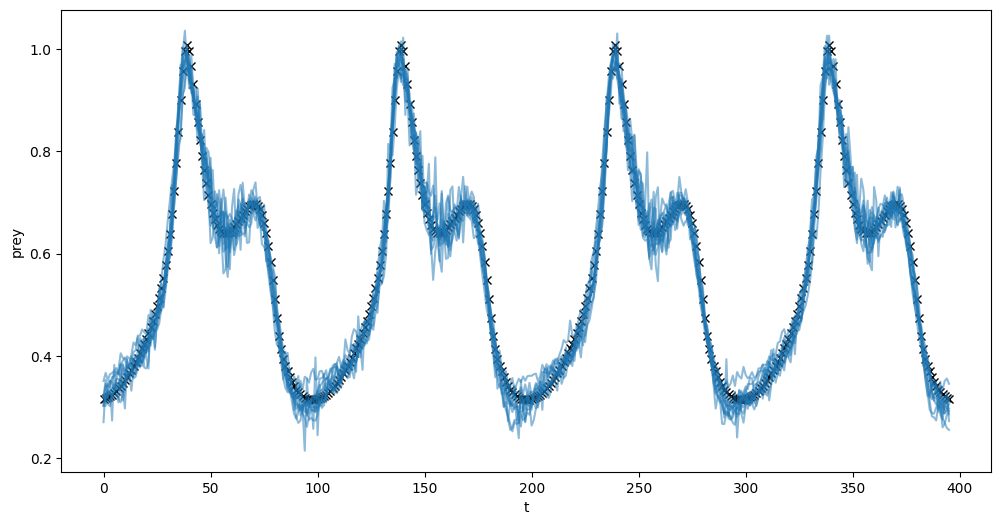

In [11]:
samples = m.simulate_latent_montecarlo_correlated(
    y_initial=tf.constant(y_test)[: m.narx_params.max_lag],
    U=tf.constant(u_test),
    propagate_error=True,
    num_samples=100,
    std_threshold=tf.math.sqrt(tf.constant(1e-6, dtype=default_float())),
)
samples = samples.numpy()
mean, var = samples.mean(axis=0), samples.var(axis=0)

# Plot the first two moments of the response
plot_model(mean, var, x_test[m.narx_params.max_lag :], output_list=["predator", "prey"])

# Plot the sampled response
plot_model_samples(
    samples,
    x_test[m.narx_params.max_lag :],
    ["predator", "prey"],
    num_samples=10,
    alpha=0.5,
)